In this kernel we will go through a sentiment analysis on imdb dataset using LSTM.

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [6]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [7]:
testdf = pd.read_csv("/kaggle/input/steam-reviews/data_downsampled.csv")
#testdf['recommended'] = testdf.apply(lambda row: int(row['outcome']), axis = 1)
testdf = testdf.rename(columns = {"review_text":"Body"})


In [8]:
testdf = testdf.sample(10000)

In [9]:
testdf.labels.value_counts()

0    5229
1    4771
Name: labels, dtype: int64

In [10]:
x_test,y_test = testdf['Body'].values,testdf['labels'].values

In [11]:
y_test


array([0, 0, 1, ..., 1, 0, 0])

In [12]:
testdf

,Unnamed: 0,Unnamed: 0.1,game_id,upvotes,downvotes,username,numgames,num_reviews,recommend,hours_played,date,Body,game_name,labels
4335,30197,30197,839770,7,0,76561198084004954,0,30,-1,9.5,"1 July, 2021",really like difficult game feel create game fe...,Persona 3 Portable,0
28957,213697,213697,397540,0,0,87934859,106,7,-1,177.6,"22 January, 2024",story awful look remove dialogue wait characte...,Borderlands 3,0
51826,161816,161816,1244460,0,0,76561199552396395,0,3,1,24.0,"20 January, 2024",great people wide imagination creativity,Jurassic World Evolution 2,1
64439,213517,213517,397540,0,0,ernietheboss,0,199,1,118.9,"27 March, 2024",best combat far story weak feel unfinished mis...,Borderlands 3,1
16207,116778,116778,322170,0,0,76561199467223145,2,1,-1,52.7,"20 March, 2024",heart suit geoemtry dash,Geometry Dash,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60385,3023,3023,2208920,1,0,CraizyTrain0088,418,4,1,56.1,"24 November, 2023",best era opinion,Assassin's Creed Valhalla,1
8101,56773,56773,1928980,2,0,mddew4u,0,9,-1,0.5,"10 March, 2024",game mean craft systems terrible character cre...,VRChat,0
65946,25007,25007,1229240,0,0,76561197970896750,0,6,1,42.8,"5 September, 2023",love game letterr classic pixle game like fina...,Chained Echoes,1
30535,219529,219529,1962660,5,1,MagickMeat,493,175,-1,0.0,"12 September, 2023",abandoned make actual content game immediately...,Call of Duty®: Modern Warfare® II,0


In [13]:
base_csv = '/kaggle/input/steam-reviews/train_data_processed.csv'
df = pd.read_csv(base_csv)
df.head()

,Unnamed: 0,Unnamed: 0.1,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count
0,0,0,83770280,english,it suck its impossible to jump play or fight a...,1609545722,1609545722,False,2,2,0.429967,0
1,1,1,42466335,english,grrrrrrrrrrrrrrr ban without cheat i just kill...,1528019389,1528019389,False,0,0,0.000000,0
2,2,2,66315278,english,it s a good mix of action story and comedy,1585720203,1585720203,True,0,0,0.000000,0
3,3,3,60362583,english,massive punishing learning curve match making ...,1577072272,1577072272,False,15,5,0.523723,6
4,4,4,30094516,english,this game be aweful it inconsistent and matchm...,1487748399,1487748399,False,2,0,0.518305,0


In [14]:
df = df[df['review'].notna()]

In [15]:
df

,Unnamed: 0,Unnamed: 0.1,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count
0,0,0,83770280,english,it suck its impossible to jump play or fight a...,1609545722,1609545722,False,2,2,0.429967,0
1,1,1,42466335,english,grrrrrrrrrrrrrrr ban without cheat i just kill...,1528019389,1528019389,False,0,0,0.000000,0
2,2,2,66315278,english,it s a good mix of action story and comedy,1585720203,1585720203,True,0,0,0.000000,0
3,3,3,60362583,english,massive punishing learning curve match making ...,1577072272,1577072272,False,15,5,0.523723,6
4,4,4,30094516,english,this game be aweful it inconsistent and matchm...,1487748399,1487748399,False,2,0,0.518305,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99077,99995,99995,44855440,english,thu ert daudur,1537544747,1537544747,True,3,0,0.527559,0
99078,99996,99996,42502202,english,in the begin when i play monster prom it be hu...,1528173650,1528173650,False,45,8,0.584330,0
99079,99997,99997,45249911,english,pochemu khardbas ubrali,1539443546,1539443546,False,0,0,0.000000,0
99080,99998,99998,59181255,english,hey you be finally awake,1575418673,1575418673,True,0,0,0.000000,0


In [16]:
# Convert True and False to 1 and 0
df['recommended'] = df['recommended'].astype(int)

In [17]:
df.recommended.value_counts()

0    49557
1    49441
Name: recommended, dtype: int64

In [18]:
#df['labels'] = df['labels'].map({'good': 1, 'bad': 0})

In [19]:
#sampled_bad = df[df["labels"]==0].sample(len(df[df["labels"]==1]))
#sampled_bad

In [20]:
#df = pd.concat([sampled_bad, df[df["labels"]==1]])
#df

### Splitting to train and test data

We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.


In [21]:
df = df.rename(columns = {"review":"Body", "recommended":"labels"})

In [22]:
df

,Unnamed: 0,Unnamed: 0.1,review_id,language,Body,timestamp_created,timestamp_updated,labels,votes_helpful,votes_funny,weighted_vote_score,comment_count
0,0,0,83770280,english,it suck its impossible to jump play or fight a...,1609545722,1609545722,0,2,2,0.429967,0
1,1,1,42466335,english,grrrrrrrrrrrrrrr ban without cheat i just kill...,1528019389,1528019389,0,0,0,0.000000,0
2,2,2,66315278,english,it s a good mix of action story and comedy,1585720203,1585720203,1,0,0,0.000000,0
3,3,3,60362583,english,massive punishing learning curve match making ...,1577072272,1577072272,0,15,5,0.523723,6
4,4,4,30094516,english,this game be aweful it inconsistent and matchm...,1487748399,1487748399,0,2,0,0.518305,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99077,99995,99995,44855440,english,thu ert daudur,1537544747,1537544747,1,3,0,0.527559,0
99078,99996,99996,42502202,english,in the begin when i play monster prom it be hu...,1528173650,1528173650,0,45,8,0.584330,0
99079,99997,99997,45249911,english,pochemu khardbas ubrali,1539443546,1539443546,0,0,0,0.000000,0
99080,99998,99998,59181255,english,hey you be finally awake,1575418673,1575418673,1,0,0,0.000000,0


In [23]:
X,y = df['Body'].values,df['labels'].values
x_train,x_val,y_train,y_val = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
#print(f'shape of test data is {x_test.shape}')

shape of train data is (74248,)


In [24]:
len(x_train)

74248

In [25]:
len(x_val)

24750

In [26]:
x_train

array(['very impressive game especially with apex i find it difficult to manage the mods however idk but when work be awesome the ability swivel head alt key so wonderful in these arma game love it',
       'first thoughts i be in the menu prod around and i hate everything the settings remind me of destiny cursor be a circle move by your thumbstick or mouse graphics seem like placeholder stuff accidently leave in getting into game it control fine combat rather clunky though you bang against dudes enough to get an upgrade then back menus have hold down button unlock skill on tree if you let go that at any time start over why just click it xp give me also dialog feel come out diary teen goth what life but death pending ugh fuck off',
       'chat with friend ok dude but i dont have much time just one and a half hours 5 hours later finally reach objective lookout miss work irl get warn d there may be bug let it stop you from play this be the best army sim ever make',
       ..., 'ca not r

### Analysing sentiment

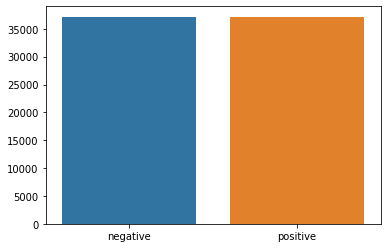

In [27]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Tokenization

In [28]:
def preprocess_string(s):


    return s

def tockenize(x_train,y_train,x_val,y_val, x_test, y_test):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.split():
            word = preprocess_string(word)
            if word in stop_words:
                continue
            word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_val, final_list_test = [],[], []
    for sent in x_train:
            sent = str(sent)
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            sent = str(sent)
            final_list_val.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_test:
            sent = str(sent)
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
    
            
#     encoded_train = [1 if label =='positive' else 0 for label in y_train]  
#     encoded_test = [1 if label =='positive' else 0 for label in y_val] 
#     return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict
    return np.array(final_list_train), y_train,np.array(final_list_val), y_val, np.array(final_list_test), y_test, onehot_dict


In [29]:
x_train,y_train,x_val,y_val,x_test, y_test, vocab = tockenize(x_train,y_train,x_val, y_val, x_test, y_test)

In [30]:
y_train

array([1, 0, 1, ..., 0, 0, 1])

In [31]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

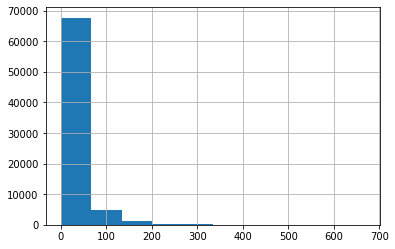

count    74248.000000
mean        24.424914
std         36.987662
min          0.000000
25%          4.000000
50%         11.000000
75%         28.000000
max        669.000000
dtype: float64

In [32]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Observations : <br>a) Mean review length = around 9.<br> b) minimum length of reviews is 0.<br>c) There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis.

### Padding

Now we will pad each of the sequence to max length 

In [33]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len), dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [34]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train, 500)
x_val_pad = padding_(x_val, 500)
x_test_pad = padding_(x_test, 500)

In [35]:
torch.from_numpy(y_val)

tensor([1, 1, 1,  ..., 1, 0, 1])

In [36]:
y_val

array([1, 1, 1, ..., 1, 0, 1])

In [37]:
#y_test

In [38]:
#torch.from_numpy(y_test)

### Batching and loading as tensor

In [39]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val))

# dataloaders
batch_size = 16

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [40]:
# create Tensor datasets
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# make sure to SHUFFLE your data
test_loader = DataLoader(test_data, batch_size=batch_size)

In [41]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([16, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 317,   1, 187],
        [  0,   0,   0,  ...,  10, 339, 508],
        [  0,   0,   0,  ..., 254,   1, 292],
        ...,
        [  0,   0,   0,  ...,   1, 119, 355],
        [  0,   0,   0,  ...,  36,  20,  29],
        [  0,   0,   0,  ..., 972, 126,  32]])
Sample input: 
 tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1])


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

### Model

In [42]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5):
        super(SentimentRNN, self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim,
                            num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
#     def init_hidden(self, batch_size):
#         ''' Initializes hidden state '''
#         # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
#         # initialized to zero, for hidden state and cell state of LSTM
#         h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
#         c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
#         hidden = (h0, c0)
#         return hidden
    def init_hidden(self):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers, 1, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers, 1, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

In [43]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [44]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [45]:
from torch.nn.utils.rnn import pad_sequence


In [46]:
# Define the variables for accuracy and loss
epoch_tr_acc = []  # List containing training accuracies
epoch_vl_acc = []  # List containing validation accuracies
epoch_tr_loss = []  # List containing training losses
epoch_vl_loss = []  # List containing validation losses

In [47]:
clip = 5
epochs = 20
valid_loss_min = np.Inf
patience = 3  # Number of epochs to wait for validation loss improvement
counter = 0   # Counter for patience
best_epoch = 0  # Store the best epoch
best_model_weights = None  # Store the best model weights

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)
        h = model.init_hidden()
        h = tuple([each.repeat(1, batch_size, 1).data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        accuracy = acc(output, labels)
        train_acc += accuracy

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)
        val_h = model.init_hidden()
        val_h = tuple([each.repeat(1, batch_size, 1).data for each in val_h])

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())
        val_losses.append(val_loss.item())

        accuracy = acc(output, labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch {epoch + 1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc * 100} val_accuracy : {epoch_val_acc * 100}')

    if epoch_val_loss <= valid_loss_min:
        best_epoch = epoch
        best_model_weights = model.state_dict()
        torch.save(best_model_weights, '../working/best_model.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, epoch_val_loss))
        valid_loss_min = epoch_val_loss
        counter = 0  # Reset counter if there's an improvement
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not decrease for {patience} consecutive epochs. Early stopping...')
            break

    print(25 * '==')

# Load the best model weights
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print(f"Loaded the model weights from epoch {best_epoch}.")


Epoch 1
train_loss : 0.45924984155541043 val_loss : 0.3858547453427207
train_accuracy : 78.35362568688718 val_accuracy : 82.52121212121212
Validation loss decreased (inf --> 0.385855).  Saving model ...
Epoch 2
train_loss : 0.3649342327618093 val_loss : 0.3615905208526385
train_accuracy : 83.87835362568688 val_accuracy : 83.76969696969697
Validation loss decreased (0.385855 --> 0.361591).  Saving model ...
Epoch 3
train_loss : 0.32244724912805317 val_loss : 0.36274861710046136
train_accuracy : 86.09659519448336 val_accuracy : 84.53737373737373
Epoch 4
train_loss : 0.2707892168590996 val_loss : 0.37945247433342777
train_accuracy : 88.58959163883202 val_accuracy : 83.67272727272727
Epoch 5
train_loss : 0.20800748046413722 val_loss : 0.43000176688987324
train_accuracy : 91.35330244585714 val_accuracy : 83.08282828282827
Validation loss did not decrease for 3 consecutive epochs. Early stopping...
Loaded the model weights from epoch 1.


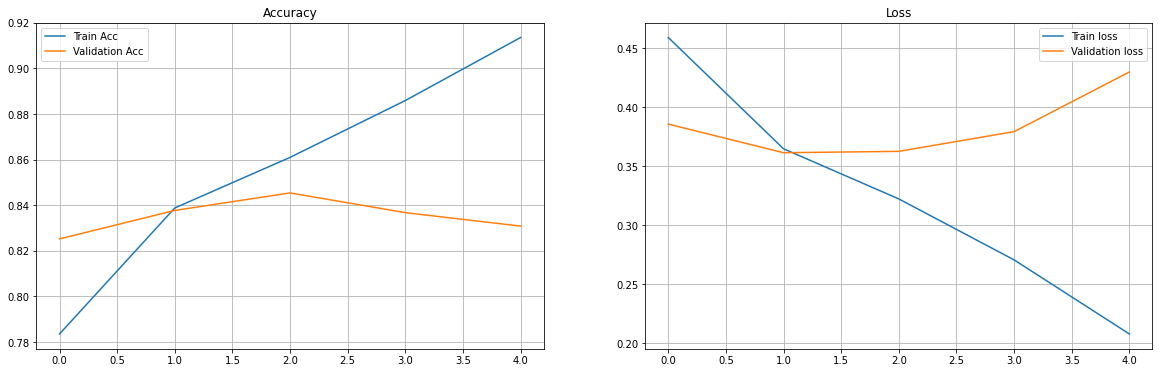

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

# Save the plot as an image
plt.savefig('training_plot.png')

plt.show()


### Load model

In [49]:
# Load the saved model weights
#model.load_state_dict(torch.load('/kaggle/input/steam-reviews/best_model.pt'))

# Set the model in evaluation mode
#model.eval()

In [50]:
device = device = torch.device("cpu")

In [51]:
device = device = torch.device("cuda")

In [52]:
model.to(device)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

### Inference

In [53]:
# make sure to SHUFFLE your data
test_loader = DataLoader(test_data, batch_size=16)

In [54]:
len(test_loader)

625

In [55]:
# Importing gc module
import gc
 
# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector 
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)

Garbage collector: collected 5 objects.


In [56]:
 torch.cuda.empty_cache()

In [57]:
outputs = []
model.eval()
c=0
for inputs, labels in test_loader:
        print(c)
        c+=1
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)
        val_h = model.init_hidden()
        val_h = tuple([each.repeat(1, batch_size, 1).data for each in val_h])

        output, val_h = model(inputs, val_h)
        outputs.append(output)
        del output, inputs, labels
        
        torch.cuda.empty_cache()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [65]:
# Concatenate the tensors along the first dimension (dimension 0)
output = torch.cat(outputs, dim=0)

print(output)

tensor([0.0068, 0.0014, 0.9910,  ..., 0.9773, 0.0130, 0.0024], device='cuda:0',
       grad_fn=<CatBackward>)


In [66]:
len(output)

10000

In [61]:
labels_np = y_test
labels_np

array([0, 0, 1, ..., 1, 0, 0])

In [68]:

# Define your threshold
threshold = 0.5

# Apply thresholding
binary_predictions = (output >= threshold).float()

# Convert to CPU if needed
binary_predictions = binary_predictions.cpu()

print(binary_predictions)


tensor([0., 0., 1.,  ..., 1., 0., 0.])


In [69]:
len(output)

10000

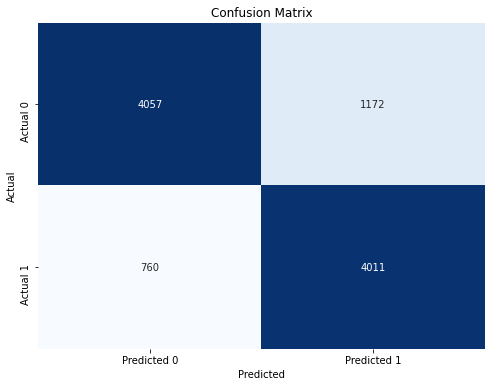

In [70]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Convert predictions to numpy array and binarize
binary_predictions_np = binary_predictions.cpu().detach().numpy()
binary_predictions_binarized = np.where(binary_predictions_np >= threshold, 1, 0)
#labels_np = labels.cpu().detach().numpy()
# Compute confusion matrix
cm = confusion_matrix(labels_np, binary_predictions_binarized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()





In [71]:
from sklearn.metrics import classification_report

# Assuming y_true contains true labels and y_pred contains predicted labels


# Print classification report
print(classification_report(labels_np, binary_predictions_binarized))


              precision    recall  f1-score   support

           0       0.84      0.78      0.81      5229
           1       0.77      0.84      0.81      4771

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [ ]:
'''
index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')
'''


In [ ]:
'''
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')
'''


Some improvement suggestions are as follow:

* Running a hyperparameter search to optimize your configurations.
* Using pretraned word embeddings like Glove word embeddings
* Increasing the model complexity like adding more layers/ using bidirectional LSTMs
